Nama : Naovi Magfiroh 

Kelas : Ular

##Langkah Pertama(Problem Solving)



Animal adalah hewan yang bisa dipelihara oleh masyarakat.Setiap hewan memiliki banyak jenis ras yang berbeda.Selain itu juga memiliki karakteristik yang berbeda pula.Pada dataset animal dapat diklasifikasikan menggunakan metode Convolutional Neural Network karena metode ini sangat cocok untuk diterapkan dalam penelitian pengenalan dan klasifikasi objek. Selain itu,CNN sangat baik jika obyek yang diklasifikasi sangat mirip dengan dataset yang sudah dilatih.

##Langkah Kedua(Image Acquisation)

Melakukan Import library

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

Melakukan koneksi ke google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Melakukan pengambilan dataset(4 animal classification)yang sudah terhubung kedalam google drive

In [ ]:
path = '/content/drive/MyDrive/ORBIT/UP CV/4-animal-classification/'

Melakukan pengecekan isi dari dataset ternyata berisi 3 file yaitu sample_submission,train,dan test

In [ ]:
print(os.listdir("/content/drive/MyDrive/ORBIT/UP CV/4-animal-classification/"))

['Sample_submission.csv', 'train', 'test']


##Langkah Ketiga(Preprocesing Image)

Melakukan split data dengan mengambil 20% dari data validation dan sisanya 80 % sebagai data training.

In [ ]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

Membuat variabel train_ds(untuk  data trainning) dengan pengambilan data trainning dengan target_size nya adalah 224 x 224 dan batch_sizenya 32.

Membuat variabel val_ds(untuk data validation)dengan pengambilan data trainning dengan target_size nya adalah 224 x 224 dan batch_sizenya 32.

In [ ]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(224 , 224),
        batch_size=32)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(224 , 224),
        batch_size=32 )

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


Hasil untuk data train_ds sebanyak 2240,sedangkan data val_ds sebanyak 560.

Visualisasi Data

Melihat total jumlah keseluruhan dataset berdasarkan kategori deer,dog,cat,dan horse

In [ ]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

data_animal = pd.DataFrame(data)
data_animal

,Name of class,Number of samples
0,deer,600
1,dog,900
2,cat,700
3,horse,600


Melihat total jumlah dataset berdasarkan plot barchart

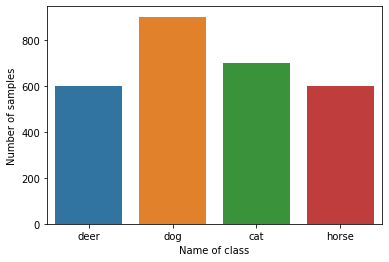

In [ ]:
sns.barplot(x=data_animal['Name of class'],y=data_animal['Number of samples'])

- Jumlah data sampel pada kelas deer yaitu 600 data 

- Jumlah data sampel pada kelas dog yaitu 900 data 

- Jumlah data sampel pada kelas cat yaitu 700 data 

- Jumlah data sampel pada keas horse yaitu 600 data 


- Bahwa mayoritas data Animal tergolong kedalam kategori kelas dog yaitu 900 data

- Kelas der dan horse mempunyai jumlah yang sama yaitu berkisar 600 data.

Menampilkan 10 gambar berwarna secara random beserta labelnya

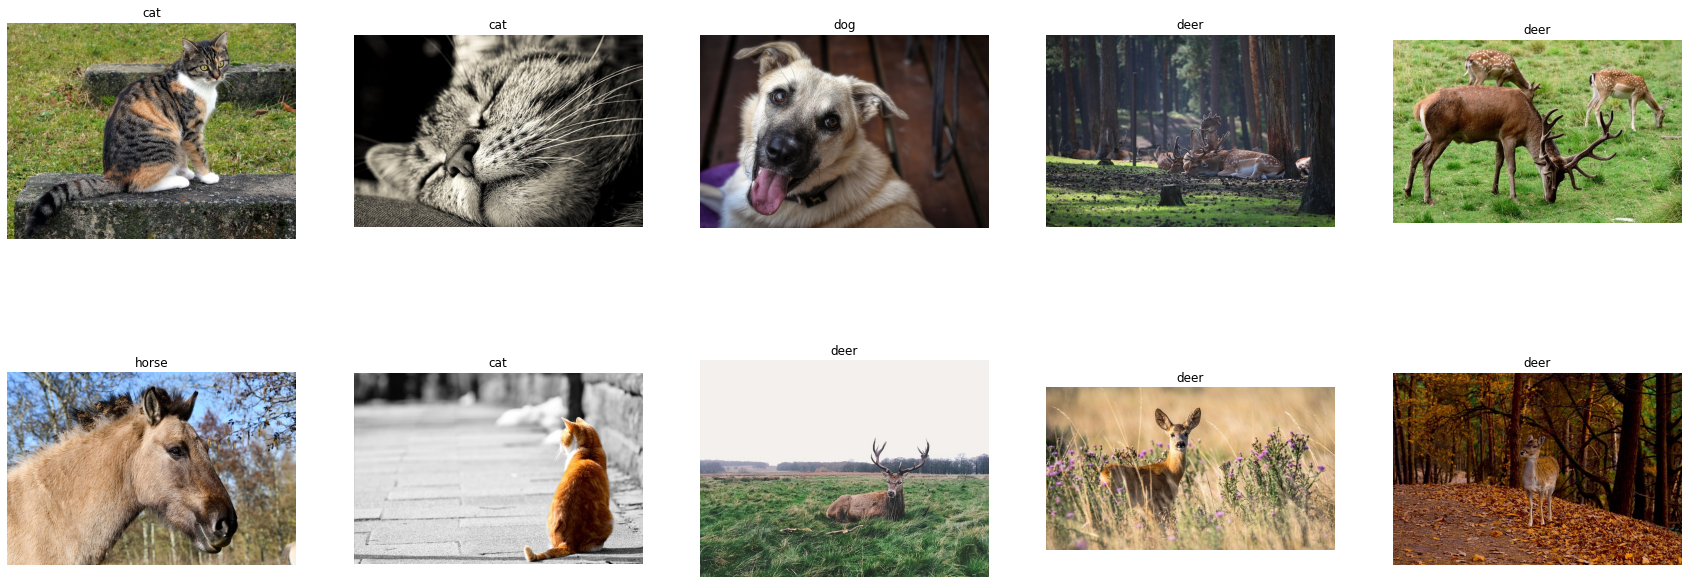

In [ ]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,600)
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

##Langkah Keempat(Modelling)

Pembuatan arsitektur menggunakan mobilenet

In [ ]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
#Menggunakan arsitektur mobilenet
model.add(mobilenet) 
#Proses Encode
model.add(GlobalAveragePooling2D()) 
#Proses Code(Mengubah bahasa komputer menjadi image)
model.add(Flatten()) 
#Proses Decode dengan menggunakan dense 1024 dengan menggunakan aktivasi relu
model.add(Dense(1024, activation="relu")) 
#Proses Decode dengan menggunakan dense 512 dengan menggunakan aktivasi relu
model.add(Dense(512, activation="relu")) 
#Proses Decode dengan menggunakan dense 4 dengan menggunakan aktivasi softmax(fungsi aktivasi yang digunakan pada layer output)
model.add(Dense(4, activation="softmax" , name="classification"))  

17235968/17225924 [==============================] - 0s 0us/step


Melatih model trainning menggunakan learning rate 0.0015 dengan momentum 0.5,dan loss function ketegori entropy.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0015,momentum=0.5), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 4)                 2

##Langkah Kelima(Training and Evaluating)

Melakukan proses evaluasi dari data trainning dan validation menggunakan epoch 18

In [ ]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 18)

Epoch 1/18
70/70 [==============================] - 640s 9s/step - loss: 0.9705 - accuracy: 0.6393 - val_loss: 0.6410 - val_accuracy: 0.8286
Epoch 2/18
70/70 [==============================] - 467s 7s/step - loss: 0.4875 - accuracy: 0.8759 - val_loss: 0.4142 - val_accuracy: 0.8714
Epoch 3/18
70/70 [==============================] - 468s 7s/step - loss: 0.3285 - accuracy: 0.9121 - val_loss: 0.2950 - val_accuracy: 0.9304
Epoch 4/18
70/70 [==============================] - 464s 7s/step - loss: 0.2516 - accuracy: 0.9295 - val_loss: 0.2401 - val_accuracy: 0.9411
Epoch 5/18
70/70 [==============================] - 467s 7s/step - loss: 0.2119 - accuracy: 0.9411 - val_loss: 0.2188 - val_accuracy: 0.9339
Epoch 6/18
70/70 [==============================] - 465s 7s/step - loss: 0.1825 - accuracy: 0.9473 - val_loss: 0.1862 - val_accuracy: 0.9446
Epoch 7/18
70/70 [==============================] - 461s 7s/step - loss: 0.1579 - accuracy: 0.9554 - val_loss: 0.1740 - val_accuracy: 0.9500
Epoch 8/18
70

- Hasil loss menyatakan nilai loss function di training set sebesar 0.0620.Sedangkan hasil val_loss   menyatakan nilai loss function di test set (validation) sebesar  0.1369 

- Hasil accuracy menyatakan nilai accuracy di training set sebesar 0.9817.Sedangkan hasil val_accuracy menyatakan nilai accuracy di test set (validation) sebesar 0.9536

Menampilkan plot  evaluasi  nilai akurasi dan loss dari data validation

18/18 [==============================] - 36s 2s/step - loss: 0.1376 - accuracy: 0.9589


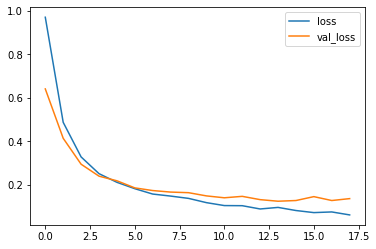

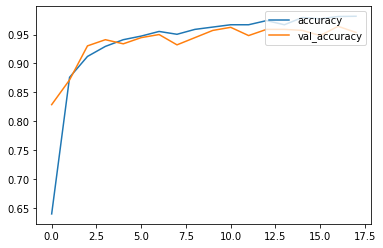

In [ ]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

Hasil pengujian arsitektur MobileNet pada data 4 Animal Calssification untuk semua kondisi menghasilkan nilai loss function sebesar 0.1376 dan nilai akurasi rata-rata sebesar 95,89%.

Kesimpulan 

Semakin kecil nilai loss function yang dihasilkan maka semakin tinggi nilai akurasi yang dihasilkan.

##Langkah Keenam(Preparing for Submission)

In [ ]:
sub_csv ='/content/drive/MyDrive/ORBIT/UP CV/4-animal-classification/Sample_submission.csv'
path_test = '/content/drive/MyDrive/ORBIT/UP CV/4-animal-classification/test/test'

In [ ]:
data_animal_sub = pd.read_csv(sub_csv)
image_id = data_animal_sub['ID']
data_animal_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [ ]:
from tensorflow.keras.preprocessing.image import load_img

labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))

In [ ]:
data_animal_sub['Label'] = labels
data_animal_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [ ]:
data_animal_sub.to_csv('submission_file.csv',index=False)